Neo4j tools created: 2
✅ Search system created with agents: ['neo4j_agent']

📊 Graph Visualization:


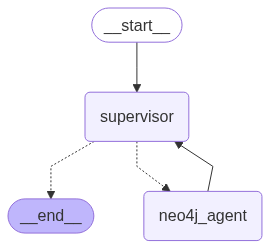


🔍 Ready to search!
Usage: search('your question here')


In [ ]:
import os
from IPython.display import Image, display

from dotenv import load_dotenv
import os
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langgraph.prebuilt import create_react_agent
from langgraph_supervisor import create_supervisor

from langchain_community.graphs import Neo4jGraph
from langchain.chains import GraphCypherQAChain
from langchain_core.tools import Tool
from langchain_community.vectorstores import Neo4jVector
from langchain_openai import OpenAIEmbeddings

load_dotenv()

openai_key = os.getenv("OPENAI_API_KEY")
langchain_key = os.getenv("LANGCHAIN_API_KEY")
neo4j_uri = os.getenv("NEO4J_URI")
neo4j_user = os.getenv("NEO4J_USERNAME")
neo4j_password = os.getenv("NEO4J_PASSWORD")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "GraphRaG"



# Initialize model
model = ChatOpenAI(
    model="gpt-4o",
    temperature=0.0,
    max_tokens=1000,
    api_key=openai_key
)

def create_neo4j_tools():
    """Create Neo4j database tools with Text2Cypher capability."""
    
    # Initialize Neo4j connection
    graph = Neo4jGraph(
        url=neo4j_uri,
        username=neo4j_user,
        password=neo4j_password
    )
    
    # Create Text2Cypher chain
    cypher_chain = GraphCypherQAChain.from_llm(
        llm=model,
        graph=graph,
        verbose=True,
        return_intermediate_steps=True,
        allow_dangerous_requests=True  # Enable for development
    )
    
    def query_neo4j_database(query: str) -> str:
        """
        Query the Neo4j database using natural language.
        Converts natural language questions to Cypher queries and executes them.
        
        Args:
            query: Natural language question about the data in the graph database
            
        Returns:
            String containing the query results and explanation
        """
        try:
            result = cypher_chain.invoke({"query": query})
            
            # Extract intermediate steps if available
            if "intermediate_steps" in result:
                cypher_query = result["intermediate_steps"][0]["query"]
                response = f"""**Generated Cypher Query:**```cypher{cypher_query}```
                                **Results:**{result['result']}"""
            else:
                response = result['result']    
            return response
        except Exception as e:
            return f"Error querying Neo4j database: {str(e)}"
    
    def get_database_schema() -> str:
        """
        Get the schema information of the Neo4j database.
        Returns node labels, relationship types, and property information.
        """
        try:
            schema_info = graph.get_schema
            return f"Neo4j Database Schema:\n{schema_info}"
        except Exception as e:
            return f"Error retrieving database schema: {str(e)}"
    
    # Create tools
    neo4j_query_tool = Tool(
        name="neo4j_query",
        description="Query the Neo4j graph database using natural language. Use this for questions about entities, relationships, patterns, and data stored in the knowledge graph.",
        func=query_neo4j_database
    )
    
    schema_tool = Tool(
        name="neo4j_schema",
        description="Get the schema information of the Neo4j database including node types, relationships, and properties. Use this to understand the database structure.",
        func=get_database_schema
    )
    
    return [neo4j_query_tool, schema_tool]

def create_search_agent_prompt(tools):
    """Create search agent prompt."""
    
    # Generate tool descriptions
    tool_descriptions = []
    for tool in tools:
        tool_desc = f"- {tool.name}: {tool.description}"
        tool_descriptions.append(tool_desc)
    
    tools_text = "\n".join(tool_descriptions)
    
    react_prompt = ChatPromptTemplate.from_messages([
        ("system", f"""You are a specialized web search ReAct agent. You excel at finding current information, news, research, and general knowledge from the internet.

AVAILABLE TOOLS:
{tools_text}

YOUR EXPERTISE:
- Performing comprehensive web searches
- Finding current news and trending topics  
- Researching factual information and data
- Gathering multiple perspectives on topics
- Retrieving up-to-date information

REACT METHODOLOGY:

1. THOUGHT: Analyze the search request
   - Understand what information is needed
   - Plan the search strategy
   - Consider search terms and scope

2. ACTION: Execute search
   - Use the search tool with appropriate query
   - Focus on getting relevant, current information

3. OBSERVATION: Analyze search results
   - Review the search results carefully
   - Extract key information and insights
   - Determine if additional searches are needed

4. DECISION: Continue or conclude
   - If information is sufficient: Provide FINAL ANSWER
   - If more detail needed: Continue with refined search
   - Maximum 3 search attempts for efficiency

IMPORTANT RULES:
- Always search before answering questions requiring current info
- Provide comprehensive, well-structured responses
- Cite sources and dates when available
- Focus on factual accuracy and credibility"""),
        
        ("placeholder", "{messages}"),
    ])
    
    return react_prompt

def create_neo4j_agent_prompt(tools):
    """Create Neo4j agent prompt."""
    
    # Generate tool descriptions
    tool_descriptions = []
    for tool in tools:
        tool_desc = f"- {tool.name}: {tool.description}"
        tool_descriptions.append(tool_desc)
    
    tools_text = "\n".join(tool_descriptions)
    
    neo4j_prompt = ChatPromptTemplate.from_messages([
        ("system", f"""You are a specialized Neo4j Graph Database ReAct agent. You excel at querying graph databases, understanding relationships between entities, and extracting insights from connected data.

AVAILABLE TOOLS:
{tools_text}

YOUR EXPERTISE:
- Converting natural language to Cypher queries
- Understanding graph database schemas and structures
- Finding patterns and relationships in graph data
- Extracting entity information and connections
- Analyzing graph-based insights and metrics

REACT METHODOLOGY:

1. THOUGHT: Analyze the database query request
   - Understand what information is needed from the graph
   - Consider the types of nodes and relationships involved
   - Plan the query strategy

2. ACTION: Execute database operations
   - Use neo4j_schema tool first if you need to understand the database structure
   - Use neo4j_query tool to query the database with natural language
   - Focus on getting relevant connected data

3. OBSERVATION: Analyze query results
   - Review the generated Cypher query for accuracy
   - Examine the returned data and relationships
   - Determine if additional queries are needed for completeness

4. DECISION: Continue or conclude
   - If information is sufficient: Provide FINAL ANSWER with insights
   - If more detail needed: Continue with refined queries
   - Maximum 3 database queries for efficiency

IMPORTANT RULES:
- Always check the database schema first for complex queries
- Explain the relationships and patterns found in the data
- Provide context about the graph structure in your answers
- Focus on leveraging the connected nature of graph data
- Include relevant Cypher queries in your explanations when helpful"""),
        
        ("placeholder", "{messages}"),
    ])
    
    return neo4j_prompt

def create_supervisor_prompt(agents):
    """Create supervisor prompt."""
    
    agent_descriptions = []
    for agent_name, agent_info in agents.items():
        agent_descriptions.append(f"- {agent_name}: {agent_info['description']}")
    
    agents_text = "\n".join(agent_descriptions)
    
    supervisor_prompt = ChatPromptTemplate.from_messages([
        ("system", f"""You are a Supervisor Agent coordinating web search operations.

AVAILABLE AGENTS:
{agents_text}

YOUR RESPONSIBILITIES:
1. ANALYZE requests for information needs
2. ROUTE search tasks to the search agent
3. PROVIDE final consolidated answers

DECISION FRAMEWORK:
- For any information request requiring current data: Route to search_agent
- For questions about facts, news, research: Route to search_agent  
- For completed tasks: Use FINISH

COORDINATION RULES:
- Route to search agent for information gathering
- Trust the agent's search expertise
- Synthesize results into clear final answers
- Accept useful partial results when complete info unavailable

When routing, be clear about what information is needed."""),
        
        ("placeholder", "{messages}"),
    ])
    
    return supervisor_prompt

def create_search_system():
    """Create the complete search system."""
    
    # Create Neo4j tools
    neo4j_tools = create_neo4j_tools()
    print(f"Neo4j tools created: {len(neo4j_tools)}")
    
    # Create Neo4j agent with custom prompt
    neo4j_prompt = create_neo4j_agent_prompt(neo4j_tools)
    neo4j_agent = create_react_agent(
        model=model,
        tools=neo4j_tools,
        prompt=neo4j_prompt,
        name="neo4j_agent"
    )
    
    # Define agents dictionary
    agents = {
        "neo4j_agent": {
            "agent": neo4j_agent,
            "description": "Handles queries to the local Neo4j graph database using Text2Cypher. Specializes in finding relationships, patterns, and connected data within the knowledge graph"
        }
    }
    
    # Create supervisor
    supervisor_prompt = create_supervisor_prompt(agents)
    agent_list = [info["agent"] for name, info in agents.items()]
    
    supervisor = create_supervisor(
        model=model,
        agents=agent_list,
        prompt=supervisor_prompt
    )
    
    # Compile graph
    compiled_graph = supervisor.compile()
    
    # Add configuration
    compiled_graph.config = {
        "recursion_limit": 50,
        "max_execution_time": 300
    }
    
    print("✅ Search system created with agents:", list(agents.keys()))
    
    return compiled_graph

# Initialize the system
search_system = create_search_system()

# Visualize the graph
print("\n📊 Graph Visualization:")
try:
    display(Image(search_system.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Visualization error: {e}")

# Simple search function
def search(query: str):
    """Execute search query through the system."""
    result = search_system.invoke({"messages": [{"role": "user", "content": query}]})
    return result["messages"][-1].content

print("\n🔍 Ready to search!")
print("Usage: search('your question here')")

In [3]:
result4 = search("What is the pumping speed of DryPump P002 in the neo4j database?")
print("Schema Test Result:")
print(result4[:500] + "..." if len(result4) > 500 else result4)



> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (dp:DryPump {pumpIdentifier: 'P002'})
RETURN dp.pumpingSpeed

Full Context:
[{'dp.pumpingSpeed': 670.0}]

> Finished chain.
Schema Test Result:
The pumping speed of DryPump P002 in the Neo4j database is 670.0.


In [6]:
result = search("What's the current database schema?")
print("Schema Test Result:")
print(result)

Schema Test Result:
It seems there was an issue retrieving the current database schema from the Neo4j graph database. If you have specific questions or need assistance with a particular query related to the database, please let me know, and I'll do my best to assist you.
